# Parameter test

New to active nematics FEM simulation, I want to figure out a set of parameters that can generate physical results, ideally in a short time frame. This involves testing running speed for different MPI processes and different mesh geometries, etc. In this notebook, these tests are planned and documented. 

## 0 Packages

In [18]:
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
import matplotlib.pyplot as plt
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
import re
import numpy as np
import pandas as pd
import glob
import os
import psutil
import time

## 1 MPI process numbers

Parallel computing does not necessarily speed up the computation linearly. Actually, even speedup itself is not always guaranteed. This is due to the runtime overhead of the communication between processes. 

In this test, the number of processes `mpirun -n` parameter ranges from 1 to 9. The mesh being tested consists of ~4000 elements. Indeed, the linear speedup is not observed. Instead, we observe the shortest run time at $n=3$. The run time $T$ as a function of process number $n$ is plotted below. 

In [ ]:
folder = "/home/zhengyangliu/Documents/RATSIM/MPI_speed_test/"

with open(os.path.join(folder, "result.txt"), "r") as f:
    lines = f.readlines()
import time
data = []

for line in lines:
    match = re.search(r"n=(\d+): ([\d.]+) s", line)
    if match:
        n_value = int(match.group(1))
        s_value = float(match.group(2))
        data.append({"n": n_value, "T": s_value})

df = pd.DataFrame(data)

Text(0, 0.5, 'Run time, T (s)')

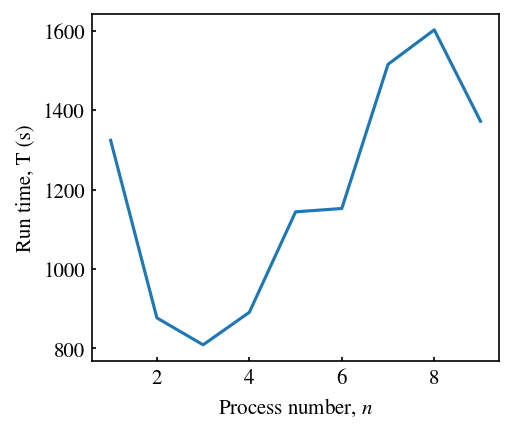

In [16]:
plt.figure(figsize=(3.5, 3), dpi=150)
plt.plot(df["n"], df["T"])
plt.xlabel("Process number, $n$")
plt.ylabel("Run time, T (s)")

## 2 Length scale 

The equations we simulated are dimensionless, and the actual length scale in the system is somewhat obscure to me. It is desired to directly measure it in simulation in a simple domain. 

In this test, we run the simulation in a square domain 100 x 100. We vary the activity coefficient $\alpha\in[1, 2, 4, 8, 16, 32]$. We aim to observe the characteristic length scale in the resulting velocity field, which can guide our design of the ratchet channels, as well as anchor the simulation length scale to the real length scale. 

## 3 CPU usage

In [19]:
def monitor_cpu_usage(interval=1, duration=60):
    """
    Monitors system-wide CPU usage and prints it to the console.

    Args:
        interval (int): The time interval (in seconds) between readings.
        duration (int): The total duration (in seconds) to monitor.
                        Set to 0 or a negative number for continuous monitoring
                        until the script is stopped manually (Ctrl+C).
    """
    print("--- CPU Usage Monitor ---")
    print(f"Monitoring every {interval} second(s).")
    if duration > 0:
        print(f"Total duration: {duration} seconds.")
    else:
        print("Monitoring continuously (Ctrl+C to stop).")
    print("-" * 30)

    start_time = time.time()
    try:
        while True:
            # psutil.cpu_percent() calculates the CPU utilization as a percentage.
            # The 'interval' argument makes it block for the specified seconds
            # and calculate the percentage over that interval.
            # The first call will return 0.0, so it's good to call it once
            # before the loop if you want to skip the initial 0.0 or
            # use a very small interval for the first meaningful reading.
            cpu_percent = psutil.cpu_percent(interval=interval)

            # psutil.cpu_percent(percpu=True) gives usage for each core
            # cpu_per_core = psutil.cpu_percent(interval=interval, percpu=True)

            print(f"CPU Usage: {cpu_percent:.1f}%")

            if duration > 0 and (time.time() - start_time) >= duration:
                break
    except KeyboardInterrupt:
        print("\nMonitoring stopped by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        print("--- Monitor Ended ---")

    # Example usage: Monitor for 30 seconds, updating every 2 seconds
    

    # Example usage: Monitor continuously (Ctrl+C to stop)
    # monitor_cpu_usage(interval=1, duration=0)

In [24]:
monitor_cpu_usage(interval=2, duration=30)

--- CPU Usage Monitor ---
Monitoring every 2 second(s).
Total duration: 30 seconds.
------------------------------
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 99.8%
CPU Usage: 100.0%
CPU Usage: 100.0%
CPU Usage: 100.0%
--- Monitor Ended ---


When using `mpirun -n 2`, the CPU usage is typically around 20% and the computation speed was shown to be good. So we will proceed with $n=2$ in our following tests. 

## 4 Time step

In the previous tests, I always observe spurious boundary velocity fluctuation, which looks very unphysical. I remember having smoother velocity before, but could not figure out what is the key that gives me smooth velocity field. 

As a hypothesis, smaller time step is worth trying. In this section, we test $\Delta t\in [0.01, 0.02, 0.04, 0.08]$.

After testing dt=0.01, I notice that the flow is not physical. Most directors are not moving at all. This indicates that the scale of system is too small?

## 5 System size

In this section, we try a larger system 300x300. 

## 6 Compare free-slip and no-slip

I noticed that the free-slip boundary condition I defined using the implicit method gives unphysical flow. In this section we compare the results of the two conditions. The conclusion is to keep using no-slip boundary. 

## 2 Boundary anchoring

Although the anchoring is set to be parallel, if the anchoring strength coefficient is set too small, the director tend to be perpendicular to the boudnaries. 

In this test, various anchoring strength, ranging from 

## 3 Channel width 

